In [1]:
import epoch_tools as et
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import h5py

In [2]:
from tmp import *
mne_epochs = mne.read_epochs(r"D:\RA\DRD2 project\drd2_resting-state_paper\analysis_v2\epochs\fif\epochs_5s_TAINI_101A_79602_2.13_2023-08-18_10-02-44_601_0000-epo.fif")

non_feature_columns = ['og_id', 'animal_id', 'genotype', 'batch', 'start_sample', 'end_sample',
    'start_frame', 'end_frame', 'ploss_ratio', 'bad', 'nose_max_speed',
    'center_max_speed', 'tail_max_speed', 'transmitter_max_speed']

# (Optional) specifiy subject/animal_id or condition
animal_id = "79602"
condition = "WT"

# Initialize the Epochs object
subset = et.Epochs(mne_epochs, non_feature_columns, animal_id, condition)

# Subset
subset = subset[subset.metadata['bad']!=True]

# Load DLC Features
dlc_features = pd.read_csv(r"D:\RA\various analyses\dlc_feature_engineering\pipeline_out\79602DLC_Resnet50_resting_state_v2Dec5shuffle1_snapshot_190_filtered_interpolated_10.csv")

# Apply windowing based on start_frame	end_frame from epochs.metadata
dlc_features_windowed = sliding_window_features(df = dlc_features, window_pairs = subset.metadata[['start_frame', 'end_frame']].values)
dlc_features_windowed = dlc_features_windowed.rename(columns={'window_start': 'start_frame', 'window_end': 'end_frame'})

# Merge the metadata with the DLC features
dlc_features_windowed_merged = pd.merge(subset.metadata, dlc_features_windowed, on=['start_frame', 'end_frame'], how='outer')

# Add on the features from the epochs object
subset.metadata = dlc_features_windowed_merged

Reading D:\RA\DRD2 project\drd2_resting-state_paper\analysis_v2\epochs\fif\epochs_5s_TAINI_101A_79602_2.13_2023-08-18_10-02-44_601_0000-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...    4999.45 ms
        0 CTF compensation matrices available
Adding metadata with 257 columns
3777 matching events found
No baseline correction applied
0 projection items activated


In [3]:
cols= ['center_speed_mean', 'center_speed_max', 'neck_right_side_right_hip_tail_base_left_hip_left_side_area_mean', 
        'neck_right_side_right_hip_tail_base_left_hip_left_side_area_variance', 'center_transmitter_length_mean', 
        'left_side_right_side_length_mean', 'center_neck_angular_change_mean', 'center_neck_angular_change_max', 'center_neck_angular_change_entropy']

all_cols = cols + ['OFC_L_delta', 'OFC_L_theta', 'OFC_L_alpha', 'OFC_L_beta', 'OFC_L_gamma', 'OFC_L_theta_delta_ratio', 'EMG_L_zero_crossing_rate', 'EMG_L_gamma', 'EMG_L_entropy']

subset.create_feature_subset(features=all_cols)
feats3 = subset.get_features(
    scaler='standard',
    dropna=True,
    ch_names=None,
    as_array=False
)

In [4]:
min_cluster_size_perc = 0.5

reducer = "umap"
reducer_params = {'n_components': 7, 'random_state':42}

clusterer = "hdbscan"
clusterer_params = {'min_cluster_size': 20}


subset.cluster_data(
    reducer = reducer,
    clusterer = clusterer,
    reducer_params = reducer_params,
    clusterer_params = clusterer_params
)

c:\Users\basil\anaconda3\envs\taini_epochs\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\basil\anaconda3\envs\taini_epochs\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\basil\anaconda3\envs\taini_epochs\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\basil\anaconda3\envs\taini_epochs\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


<Axes: xlabel='dim1', ylabel='dim2'>

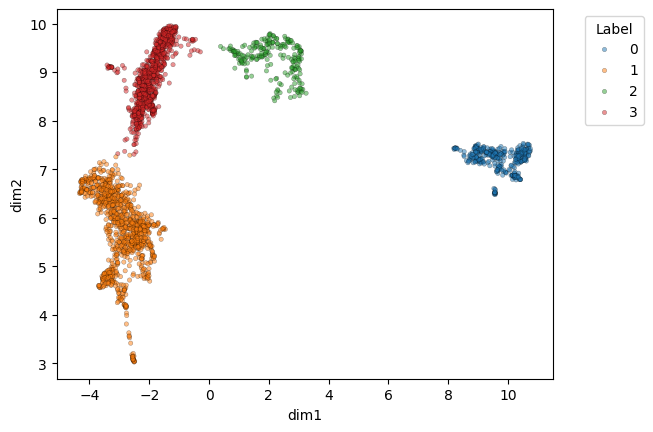

In [5]:
subset.plot_dim_reduction()

d:\RA\custom_libs\epoch_tools\epoch_tools\epochs.py:586: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Label')


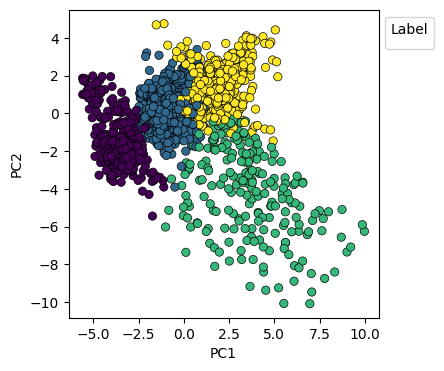

In [6]:
subset.plot_simple_pca()

c:\Users\basil\anaconda3\envs\taini_epochs\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


<Axes: xlabel='UMAP 1', ylabel='UMAP 2'>

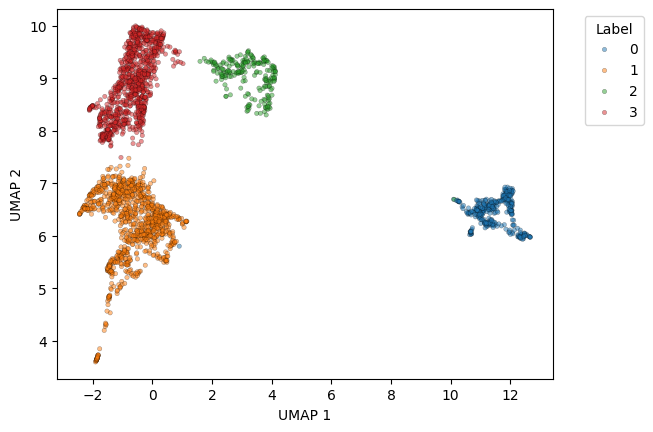

In [7]:
subset.plot_umap(9)

c:\Users\basil\anaconda3\envs\taini_epochs\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


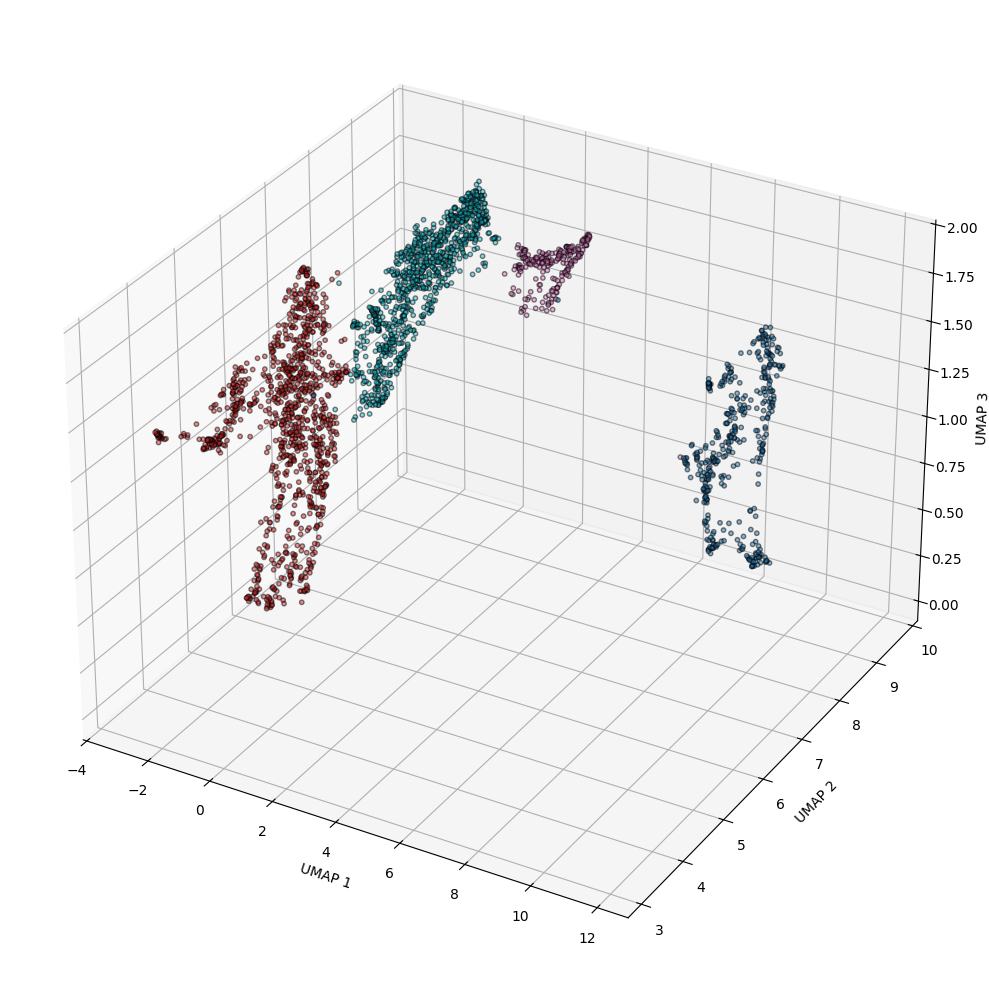

In [23]:
subset.plot_umap(9, plot3d=True)
plt.tight_layout()

In [8]:
ci = et.ClusterInterpreter(subset, model_type='random_forest', random_state=42)
ci.fit()

Model trained on 2123 samples. Held out 531 for testing.


In [9]:
ci.get_accuracy()


0.9661016949152542

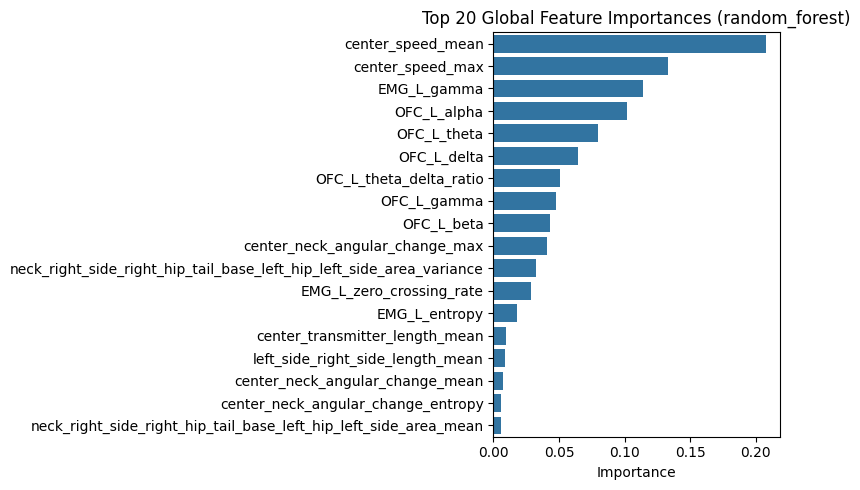

In [11]:
ci.plot_feature_importances_global()

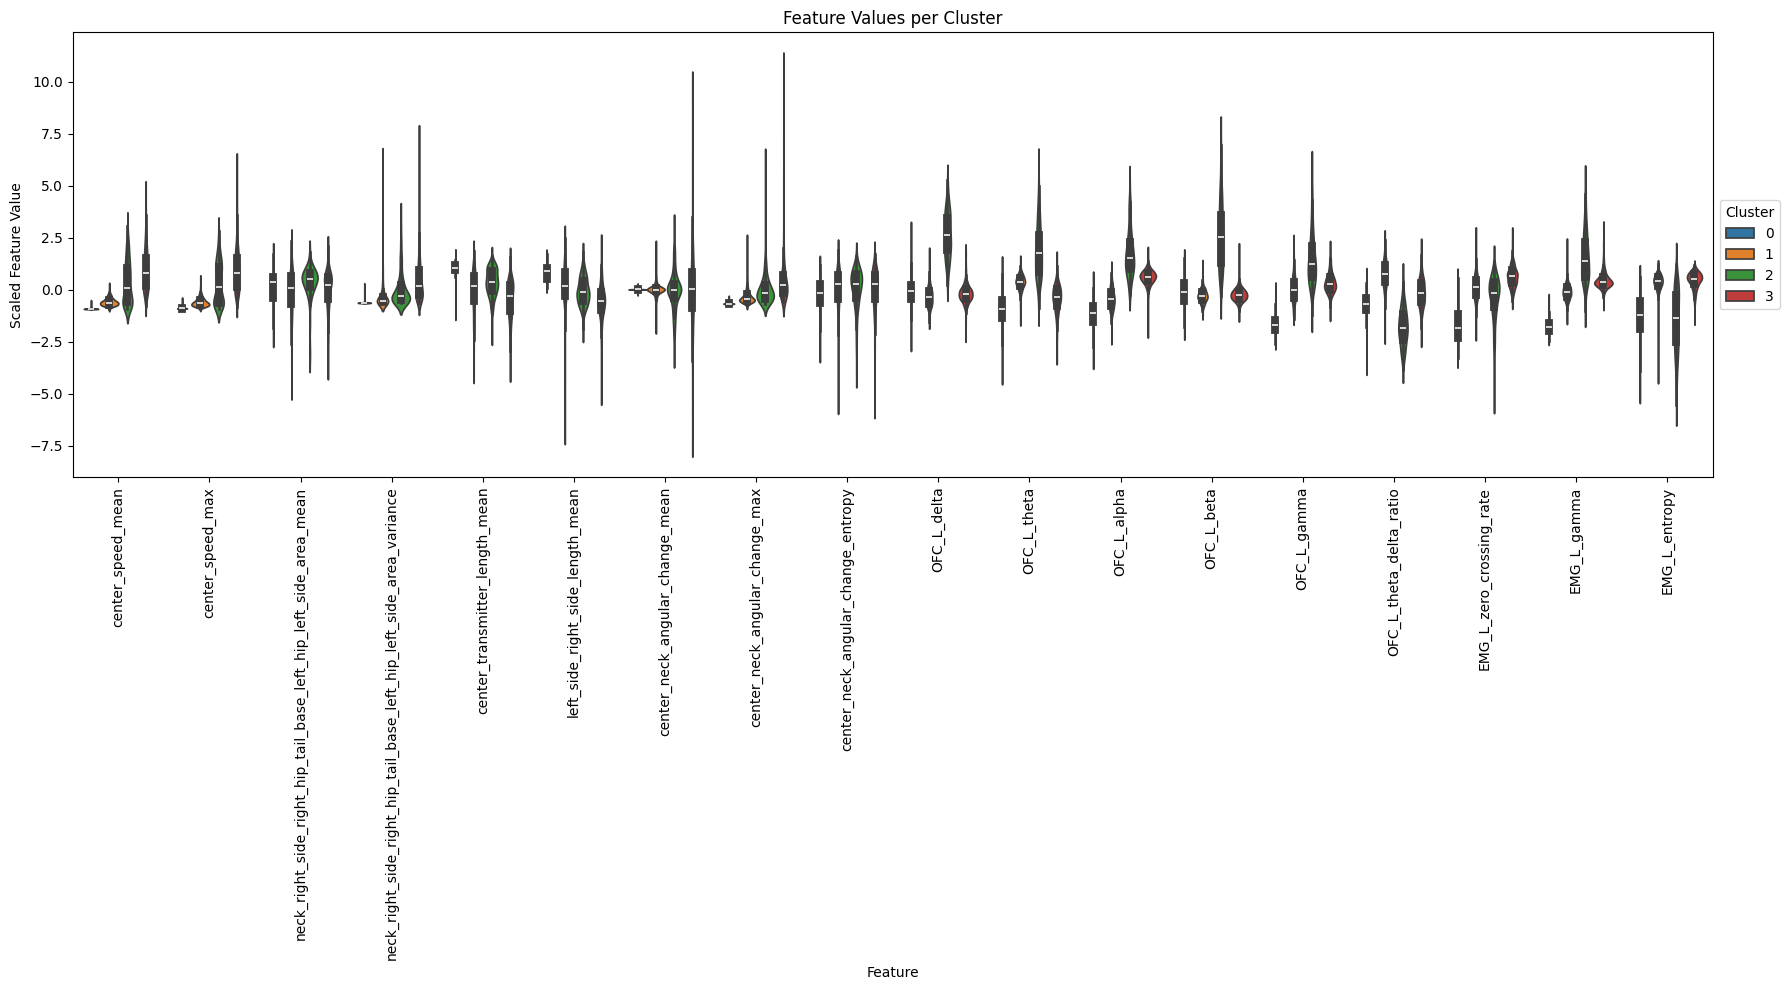

<Axes: title={'center': 'Feature Values per Cluster'}, xlabel='Feature', ylabel='Scaled Feature Value'>

In [17]:
ci.plot_feature_values(figsize=(18, 10))

AttributeError: 'Legend' object has no attribute 'legend'

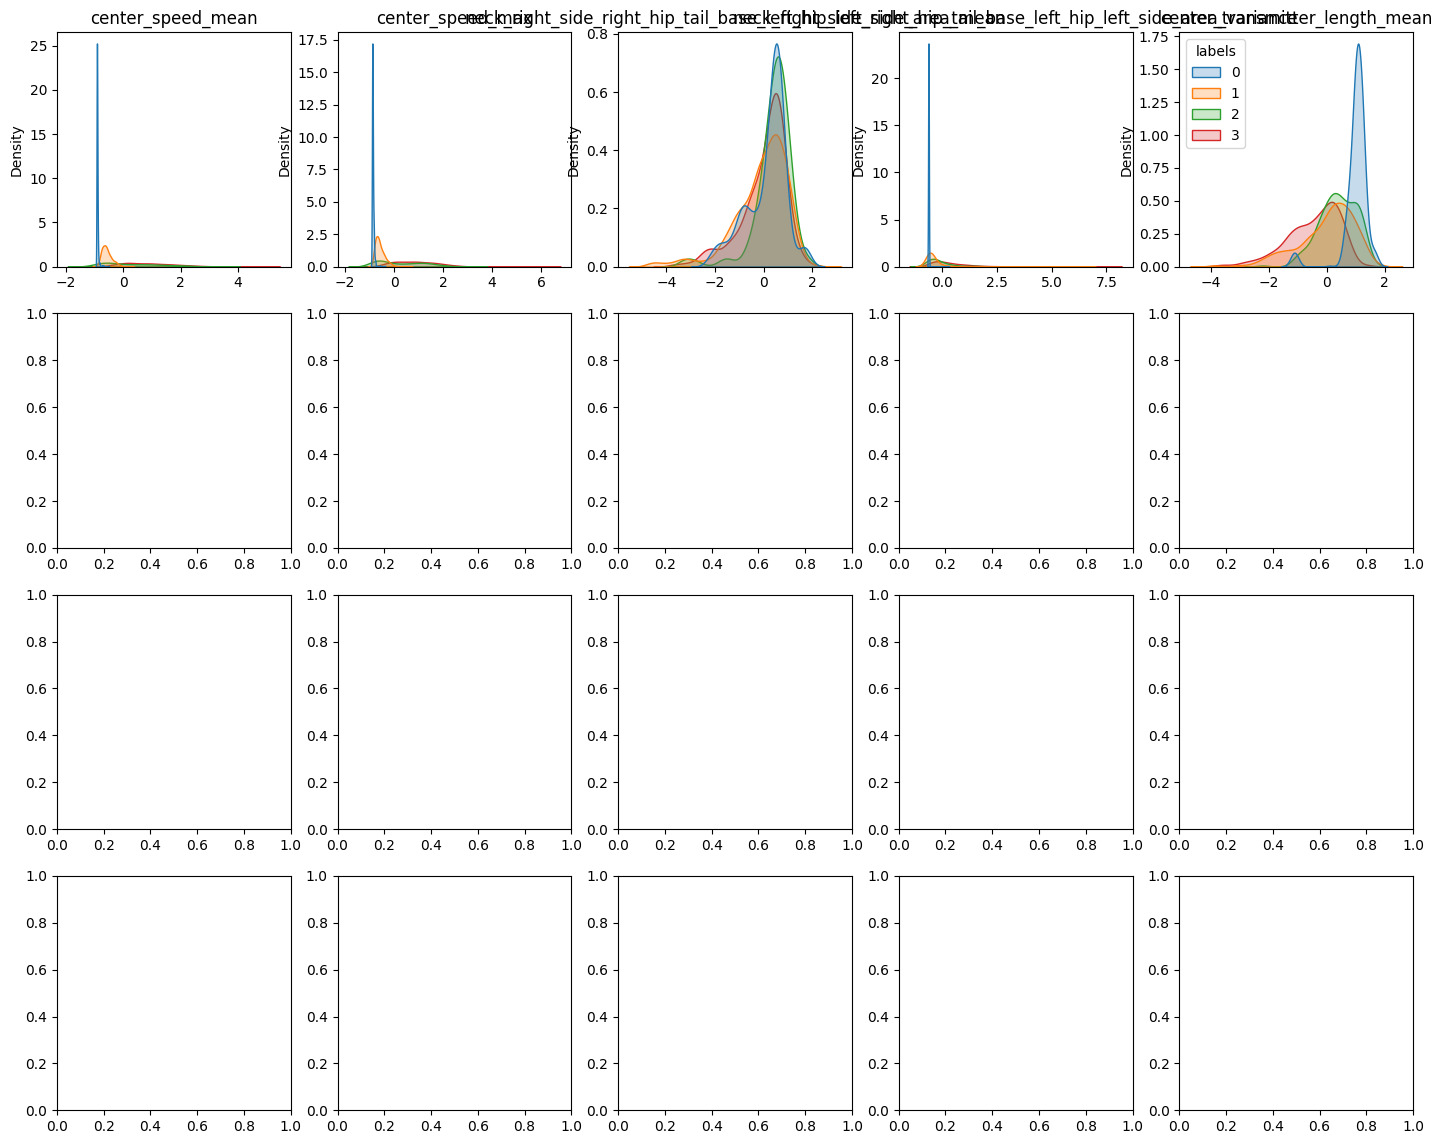

In [18]:
ci.plot_feature_density()

c:\Users\basil\anaconda3\envs\taini_epochs\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


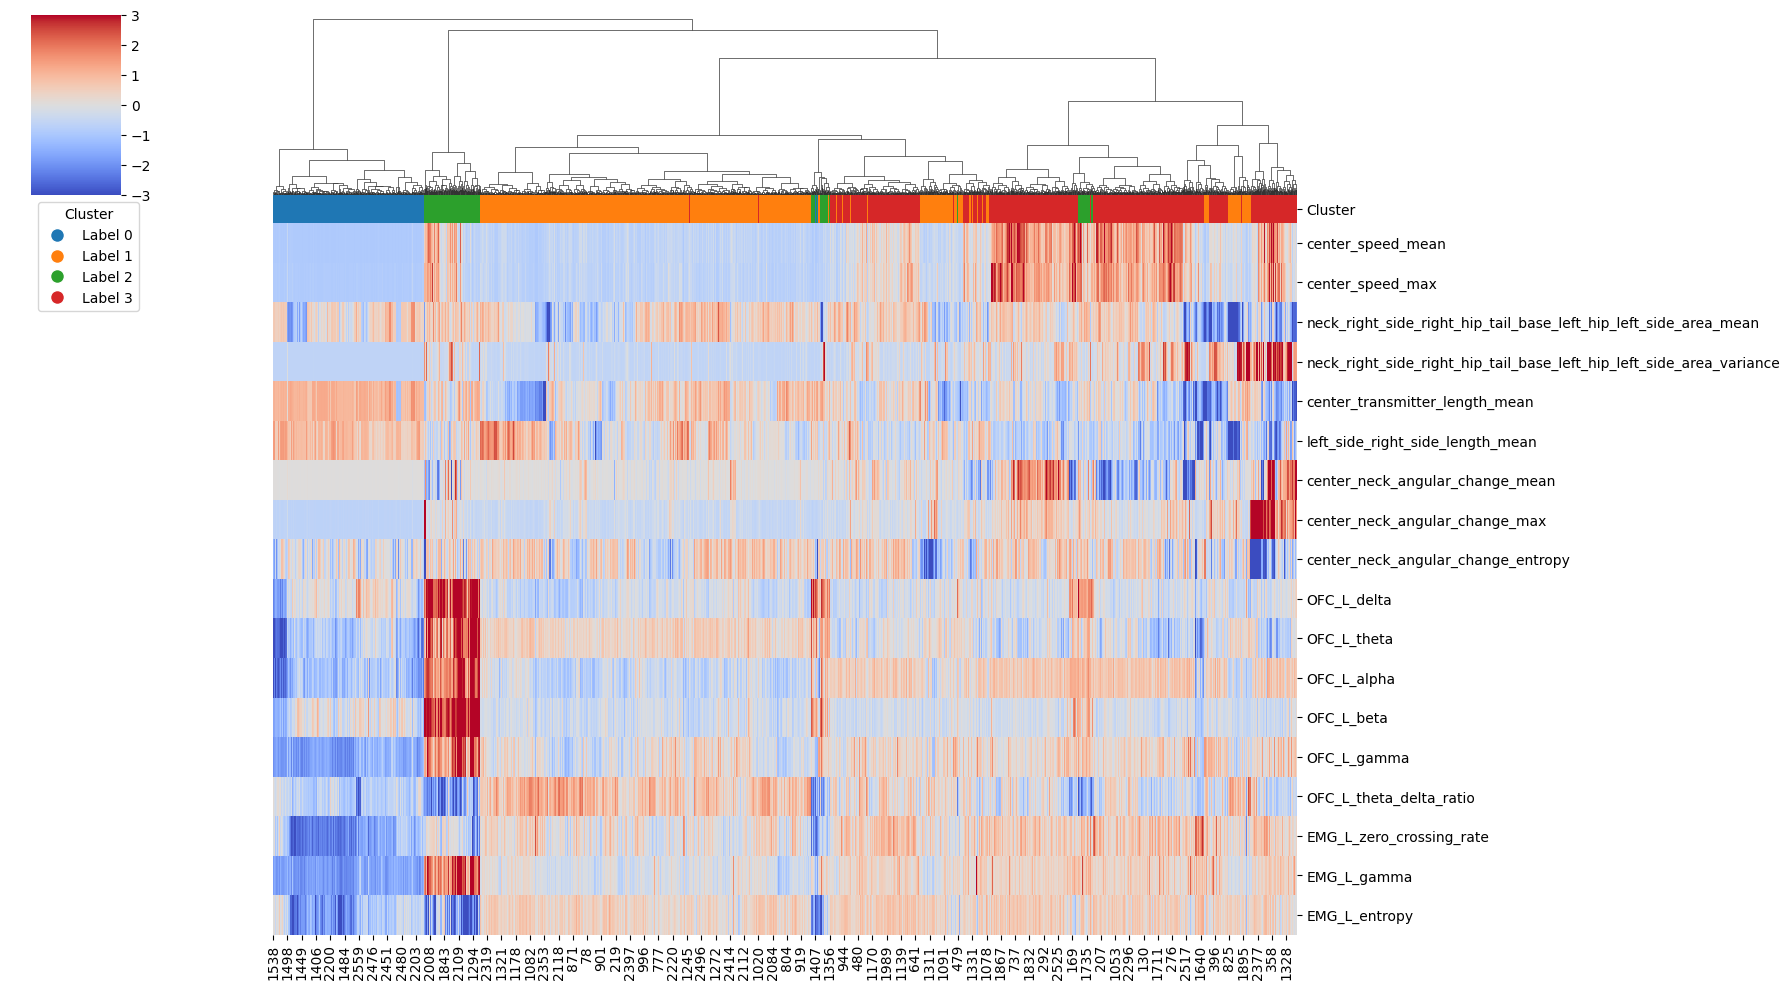

In [21]:
ci.plot_feature_hierarchy(display=False, figsize=(18, 10))

<Axes: title={'center': 'Feature Correlation Matrix'}>

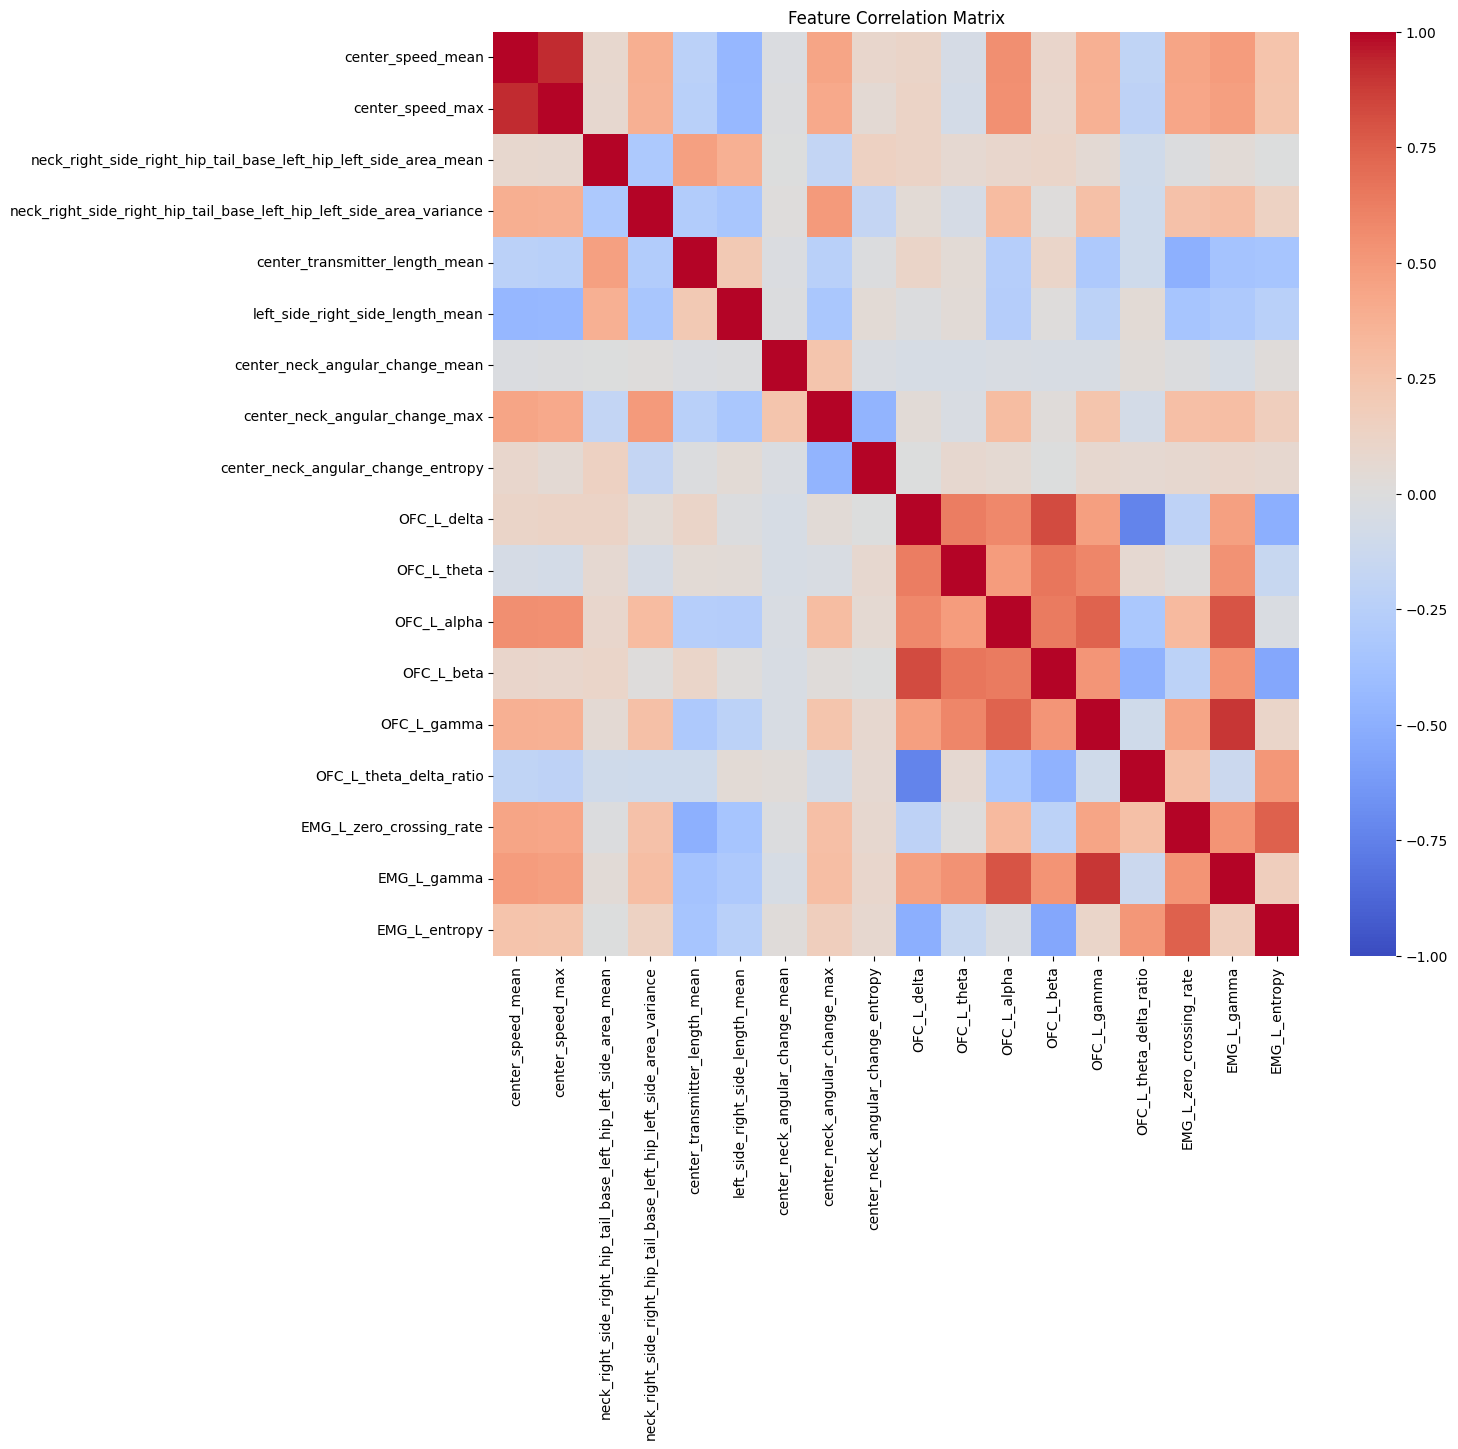

In [24]:
subset.plot_feature_correlation()